# Improving model performance with xfeat, RAPIDS and Optuna


## Introduction

Feature Engineering is the processing of transforming raw data into features that can represent the underlying patterns of the data better. They can help boost accuracy by a great deal and improve the ability of the model to generalise on unseen data. Every data scientist knows the importance of feature engineering. Spending some time thinking about how best to apply and combine the available features can be very meaningful.

Hyper parameter Optimisation is another such process which can help complement a good model by tuning it's hyperparameters, which can have a tremendous impact on the accuracy of the model.

The time and resources required for these processes are generally the reason they're overlooked. With xfeat, RAPIDS and Optuna - we aim to bridge these gaps and elevate the performance.

## What is Optuna?
[Optuna](https://github.com/optuna/optuna) is a lightweight framework for automatic hyperparameter optimization. It provides a define-by-run API, which makes it easy to adapt to any already existing code that we have and enables high modularity and the flexibility to construct hyperparameter spaces dynamically. By simply wrapping the objective function with Optuna can help perform a parallel-distributed HPO search over a search space. As we'll see in this notebook.

## What is xfeat?
[xfeat](https://github.com/pfnet-research/xfeat) is a feature engineering & exploration library using GPUs and Optuna. It provides a scikit-learn-like API for feature engineering with support for Pandas, cuDF dataframes and cuPy arrays. 

## What is MLflow?
[MLflow](https://mlflow.org/) is an open source platform to manage the ML lifecycle, including experimentation, reproducibility, deployment, and a central model registry.

## What is RAPIDS?
[RAPIDS](https://rapids.ai/about.html) framework  provides a library suite that can execute end-to-end data science pipelines entirely on GPUs.  The libraries in the framework include [cuDF](https://github.com/rapidsai/cudf) - a GPU Dataframe with pandas-like API, [cuML](https://github.com/rapidsai/cuml) - implement machine learning algorithms that provide a scikit-learn-like API and many more. You can learn more [here](https://github.com/rapidsai).

In this notebook, we'll show how one can use these tools together to develop and improve a machine learning model. We'll use Airlines dataset (20M rows) to predict if a flight will be delayed or not. We'll explore how to use Optuna with RAPIDS and the speedups that we can achieve with the integration of these, and to see the improvements with GPU speedups. There's a CPU version of this notebook available in the repository here - `optuna/notebooks/jupytercon_demo/RAPIDS_xfeat_Optuna-CPU.ipynb`.


### Prerequisites

You need to have the following libraries installed - 

- MLFlow, Optuna, plotly, kaleido

Uncomment and run the following cell to install these packages. Restart the kernel after you've installed the packages and then run the notebook.

In [ ]:
# !pip install mlflow
# !pip install optuna
# !pip install plotly
# !pip install kaleido
# !pip install xfeat

In [2]:
import time
import json
import requests
import logging
from contextlib import contextmanager

import numpy as np

import cupy
import cudf
import cuml
from cuml import LogisticRegression
from cuml.metrics import roc_auc_score
from cuml.model_selection import train_test_split
from cuml.preprocessing.LabelEncoder import LabelEncoder
from cuml.preprocessing.TargetEncoder import TargetEncoder

import mlflow
import mlflow.sklearn
from  mlflow.tracking import MlflowClient
from mlflow.models.signature import infer_signature

import optuna
import sklearn
from optuna.integration.mlflow import MLflowCallback
from optuna.study import StudyDirection
from optuna.trial import TrialState
from optuna import type_checking

import xfeat
from xfeat.pipeline import Pipeline
from xfeat.num_encoder import SelectNumerical
from xfeat.selector import ChiSquareKBest
from xfeat.optuna_selector import KBestThresholdExplorer
from xfeat import ArithmeticCombinations, Pipeline, SelectNumerical
from functools import partial

In [3]:
# Helping time blocks of code
@contextmanager
def timed(txt):
    t0 = time.time()
    yield
    t1 = time.time()
    print("%32s time:  %8.5f" % (txt, t1 - t0))

## Data Acquisition

We'll use the cell below to download the data. The file_name specifies which of the two available files we want to use. The two files are - `airline_small.parquet` (smaller file) and `airline_20000000.parquet`. By default, we use the smaller file. You are free to change it for experimentation.

Set the `download_data=True` and `data_dir` to a local path in your system to download the data into the path of `data_dir`

In [4]:
import os
download_data = True

file_name = 'airline_small.parquet' # NOTE: Change to airline_20000000.parquet to use a larger dataset

data_dir = "data/" # NOTE: Change to a local path where you want to save the file
INPUT_FILE = os.path.join(data_dir, file_name)

In [5]:
if download_data:
    from urllib.request import urlretrieve

    if os.path.isfile(INPUT_FILE):
            print(f" > File already exists. Ready to load at {INPUT_FILE}")
    else:
        # Ensure folder exists
        os.makedirs(data_dir, exist_ok=True)

    url = "https://rapidsai-cloud-ml-sample-data.s3-us-west-2.amazonaws.com/" + file_name

    urlretrieve(url= url,filename=INPUT_FILE)

    print("Completed!")

 > File already exists. Ready to load at data/airline_small.parquet
Completed!


### MLflow Configuration

For tracking the hyperparameter optimisation expriments, we will use MLFlow. In the next cell, the required variables are set up along with the callback class `RAPIDSMLflowCallback` that we will pass to Optuna for tracking.

In [6]:
MLFLOW_TRACKING_URI='sqlite:////tmp/mlflow-db.sqlite'
MLFLOW_MODEL_ID = "rapids-optuna-airline"

def get_latest_mlflow_model(tracking_uri, model_id):
    client = MlflowClient(tracking_uri=tracking_uri, registry_uri=tracking_uri)
    model = client.get_registered_model(model_id)
    latest_model = model.latest_versions[0]

    return f"MLFLOW_TRACKING_URI={tracking_uri} mlflow models serve --no-conda -m models:/{model_id}/{latest_model.version} -p 56767"

## Custom callback, for additional flexibility, based on MLflowCallback
class RAPIDSMLflowCallback(object):
    def __init__(self, tracking_uri: str = "sqlite:////tmp/mlflow-db.sqlite",
                 experiment_name: str = "RAPIDS-Optuna",
                 metric_name="value"):
        self._tracking_uri = tracking_uri
        self._experiment_name = experiment_name
        self._metric_name = metric_name
        
    def __call__(self, study, trial):
        if (self._tracking_uri is not None):
            mlflow.set_tracking_uri(self._tracking_uri)
        
        eid = mlflow.set_experiment(self._experiment_name)
        with mlflow.start_run(run_name=f"Trial: {trial.number}", experiment_id=eid, nested=True):
            trial_value = trial.value if trial.value is not None else float("nan")
            mlflow.log_metric(self._metric_name, trial_value)
            
            mlflow.log_params(trial.params)

            tags = {}
            tags["number"] = str(trial.number)
            tags["datetime_start"] = str(trial.datetime_start)
            tags["datetime_complete"] = str(trial.datetime_complete)
            tags['RAPIDS cuDF Version'] = str(cudf.__version__)
            tags['RAPIDS cuML Version'] = str(cuml.__version__)
            tags['SKlearn Version'] = str(sklearn.__version__)

            trial_state = trial.state
            if (isinstance(trial_state, TrialState)):
                tags['state'] = str(trial_state).split('.')[-1]
            
            # Set direction and convert it to str and remove the common prefix.
            study_direction = study.direction
            if isinstance(study_direction, StudyDirection):
                tags["direction"] = str(study_direction).split(".")[-1]

            tags.update(trial.user_attrs)
            distributions = {
                (k + "_distribution"): str(v) for (k, v) in trial.distributions.items()
            }
            tags.update(distributions)

            # This is a temporary fix on Optuna side. It avoids an error with user
            # attributes that are too long. It should be fixed on MLflow side later.
            # When it is fixed on MLflow side this codeblock can be removed.
            # see https://github.com/optuna/optuna/issues/1340
            # see https://github.com/mlflow/mlflow/issues/2931
            max_mlflow_tag_length = 5000
            for key, value in tags.items():
                value = str(value)  # make sure it is a string
                if len(value) > max_mlflow_tag_length:
                    tags[key] = textwrap.shorten(value, max_mlflow_tag_length)

            mlflow.set_tags(tags) 

### Feature Engineering

The following functions are defined to perform a few feature engineering tasks on the data. The feature_engineering function is called on the dataframe df, in this function we use cuML's [LabelEncoder](https://docs.rapids.ai/api/cuml/stable/api.html#cuml.preprocessing.LabelEncoder.LabelEncoder) and [TargetEncoder](https://docs.rapids.ai/api/cuml/stable/api.html#cuml.preprocessing.TargetEncoder) to encode the categorical columns. 

Arithmetic Combinations(in this notebook, adding 2 columns) on the numerical columns are done using xfeat. We specify the operator("+") and r, which is used to indicate how many columns need to be combined.

You'll also notice we use `Pipeline` from xfeat to combine two or more feature engineering tasks together. This is useful to concatenate encoders sequentially.

In this step, we will be creating a lot of features without much manual optimization. This is part of the charm of automated feature engineering - the next steps will ensure that only the most useful generated features are retained.

Read more about Feature Encoding and Pipelining with xfeat [here](https://github.com/pfnet-research/xfeat/blob/master/_docs/feature_encoding.md).

In [7]:
def feature_engineering(df_train, df_test):
    """
    Perform feature engineering and return a new train and test df with engineered features
    """
    for col in CAT_COLS:
        out_col = f'{col}_TE'
        lbl_enc = LabelEncoder(handle_unknown='ignore')
        tar_enc = TargetEncoder(n_folds=5, smooth=TARGET_ENC_SMOOTH, split_method=TARGET_ENC_SPLIT)

        df_train[col] = lbl_enc.fit_transform(df_train[col])
        df_test[col] = lbl_enc.transform(df_test[col])
        
        df_train[col] = df_train[col].fillna(0)
        df_test[col] = df_test[col].fillna(0)
        
        df_train[out_col] = tar_enc.fit_transform(df_train[col], df_train[TARGET_COL])
        df_test[out_col] = tar_enc.transform(df_test[col])

        del lbl_enc, tar_enc
        
    encoder = Pipeline([
                        SelectNumerical(),
                        ArithmeticCombinations(exclude_cols=[TARGET_COL],
                                               drop_origin=False,
                                               operator="+",
                                               r=2,
                                               output_suffix="_plus")
                    ])

    df_train = encoder.fit_transform(df_train)
    df_test = encoder.transform(df_test)
    return df_train, df_test

### Feature Selection and Hyper parameter Optimisation

Now that we have some new features, how do we know they are relevant for the task or represent anything meaningful? We use the feature selection process to do this. This helps in selection of a subset of features that are most informative. This simplifies the machine learning problem and ensures that we aren't overloading the model with unimportant features.

Optuna provides a way to choose a selector which accepts a Pipeline object from xfeat. You can see in the `feature_selection` function we define a `Pipeline` that takes in an Explorer and a Selection Algorithm (`ChiSquareKBest`). We pass this to an Optuna Study object, along with an Objective function. 

Chi squared tests are used to test the independence of two events. For Feature Selection using Chi-squared test, we aim to select features, which are highly dependent on the response. This way, we can get features that will best determine the outcome.

#### Objective Function
The objective function will be the one we optimize in Optuna Study. Objective function evaluates the model for the various values for the parameters that we are tuning and saves the results in `study.trials_dataframes()`.

Let's define the objective function for this HPO task by making use of the `train_and_eval()`. You can see that we simply choose a value for the parameters and call the train_and_eval method, making Optuna very easy to use in an existing workflow.

The objective function does not need to be changed for different samplers. Samplers are built-in options in Optuna to enable the selection of different sampling algorithms that optuna provides. Some of the available ones include - GridSampler, RandomSampler, TPESampler, etc. We'll use TPESampler for this demo, but feel free to try different samplers to notice the changes in performance. Tree-structured Parzen Estimator or TPE is based on independent sampling. It fits a Gaussian Mixture Model for each parameter associated with the best objective value in a trial `l(x)` and another GMM `g(x)` for other parameters. And it optimizes the `l(x)/g(x)` ratio to yield the best parameters.

### HPO Trials and Study
Optuna uses [study](https://optuna.readthedocs.io/en/stable/reference/study.html) and [trials](https://optuna.readthedocs.io/en/stable/reference/trial.html) to keep track of the HPO experiments. Put simply, a trial is a single call of the objective function while a set of trials make up a study. We will pick the best performing trial from a study to get the best parameters that were used in that run.

In [8]:
def train_and_eval(df_train, df_test, penalty='l2', C=1.0, l1_ratio=None, fit_intercept=True, selector=None, return_model=False):
    """
        Split the dataframe based on TARGET_COL
        Accepts the parameters to be set for the Logistic Regression model
        
        Evaluates on the split data and returns AUC score.
        
        Parameters
        ----------
        df_train, df_test: DataFrame to use for training and validation
        
        penalty, C, l1_ratio, fit_intercept: Parameters for the LogisticRegression Model
            For details refer to the documentation

        selector: xfeat selector passed via Optuna (default=None)
            When set, the slector is used to fit and transform the data
 
        return_model: Returns the fit model back to the calling fucntion (default=False)
        
        Returns
        ----------
        score: AUC score of the validation set
        classifier, signature: Returned only when return_model is set to True
    """    
    if selector:
        # Getting the label column as it is dropped in the selector
        y_train = df_train[TARGET_COL]
        y_test = df_test[TARGET_COL]

        X_train = selector.fit_transform(df_train)
        X_test = selector.transform(df_test)

    else:
        y_train = df_train[TARGET_COL]
        y_test = df_test[TARGET_COL]

        X_train = df_train[df_train.columns.difference([TARGET_COL])]
        X_test = df_test[df_test.columns.difference([TARGET_COL])]

    # Train and get accuracy
    classifier = LogisticRegression(penalty=penalty,
                                    C=C,
                                    l1_ratio=l1_ratio,
                                    fit_intercept=fit_intercept)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict_proba(X_test.values)[:, 1]
    y_pred = y_pred.astype(y_test.dtype)
    score = roc_auc_score(y_test, y_pred)

    if (return_model):
        return score, classifier, infer_signature(X_test.to_pandas(), cupy.asnumpy(y_pred))

    return score

def objective(df_train, df_test, selector, trial):
    """
    Performs the training and evaluation of the set of parameters and subset of features using selector.
    """
    selector.set_trial(trial)
    
    # Select Params
    C = trial.suggest_uniform("C", 0 , 9.0)
    penalty = trial.suggest_categorical("penalty", ['l1', 'none', 'l2'])
    l1_ratio = trial.suggest_uniform("l1_ratio", 0 , 1.0)
    fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])

    score = train_and_eval(df_train,
                           df_test,
                           penalty=penalty,
                           C=C,
                           l1_ratio=l1_ratio,
                           fit_intercept=fit_intercept,
                           selector=selector)
    return score

def feature_selection(df_train, df_test, experiment_name):
    """
    Defines the Pipeline and performs the optuna opt
    """
    artifact_path = "rapids-optuna-airline"
    selector = Pipeline(
        [
            SelectNumerical(),
            # Select features according to the k highest scores from the ChiSquared test
            KBestThresholdExplorer(ChiSquareKBest(target_col=TARGET_COL)),
        ]
    )

    mlfcb = RAPIDSMLflowCallback(
        tracking_uri=MLFLOW_TRACKING_URI,
        experiment_name=experiment_name,
        metric_name='auc')
    
    study = optuna.create_study(direction="maximize")

    mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
    mlflow.set_experiment(experiment_name)
    with mlflow.start_run(run_name=f"Optuna-HPO:{study.study_name}"):
        study.optimize(partial(objective, df_train, df_test, selector), n_trials=N_TRIALS, callbacks=[mlfcb])
        
        selector.from_trial(study.best_trial)
        selected_cols = selector.get_selected_cols()
        
        df_select_train = df_train[selected_cols]
        df_select_train[TARGET_COL] = df_train[TARGET_COL]
        
        df_select_test = df_test[selected_cols]
        df_select_test[TARGET_COL] = df_test[TARGET_COL]
        
        params = study.best_params
        score, classifier, signature = train_and_eval(df_select_train,
                                                      df_select_test,
                                                      C=params['C'],
                                                      penalty=params['penalty'],
                                                      l1_ratio=params['l1_ratio'],
                                                      fit_intercept=params['fit_intercept'],
                                                      return_model=True)
        
        with mlflow.start_run(run_name='Final Classifier', nested=True):
            mlflow.log_metric('auc', score)
            mlflow.log_params(params)
            mlflow.sklearn.log_model(classifier,
                                 signature=signature,
                                 artifact_path=artifact_path,
                                 registered_model_name="rapids-optuna-airline",
                                 conda_env='conda/conda.yaml')
    df_select = cudf.concat([df_select_train, df_select_test], sort=False)
    return study, df_select.reset_index(drop=True), classifier, score

### Set Experiment Variables

Select the number of rows and trials to run the experiment for. 

In [9]:
N_ROWS = 100000  # Number of rows to use for this experiment run
N_TRIALS = 50 # Number of trials for the HPO study

TARGET_COL = "ArrDelayBinary" 
CAT_COLS = ["Dest", "Origin", "UniqueCarrier"]

# Parameters for TagetEncoder
TARGET_ENC_SMOOTH = 0.001
TARGET_ENC_SPLIT = 'interleaved'

## GPU Run

Let's run the experiment now.

Here, we will read the data and get the default AUC score first, before optimizing our hyperparameters

In [10]:
start_time = time.time()
df_ = cudf.read_parquet(INPUT_FILE)[:N_ROWS]
# Can't handle nagative values, yet
df_ = df_.drop(["ActualElapsedTime"], axis=1)
df_train, df_test = train_test_split(df_,
                                     random_state=np.random.seed(0),
                                     shuffle=True)
print("Default performance: ", train_and_eval(df_train, df_test))

df_.head()

Default performance:  0.5


,ArrDelayBinary,Year,Month,DayofMonth,DayofWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,Origin,Dest,Distance,Diverted
0,1,1987.0,10.0,1.0,4.0,1.0,556.0,0.0,190.0,220.0,175.0,1846.0,0.0
1,0,1987.0,10.0,1.0,4.0,5.0,114.0,4.0,57.0,132.0,219.0,337.0,0.0
2,1,1987.0,10.0,1.0,4.0,5.0,35.0,5.0,351.0,116.0,130.0,987.0,0.0
3,0,1987.0,10.0,1.0,4.0,5.0,40.0,3.0,251.0,148.0,179.0,142.0,0.0
4,1,1987.0,10.0,1.0,4.0,8.0,517.0,12.0,500.0,131.0,175.0,1515.0,0.0


Let's perform the feature engineering tasks and see the performance. We'll also take a look at the dataframe after feature engineering. You can see the new features with `_TE` for TargetEncoded columns and `_plus` for additive features. Our 13 column dataset has grown to 121 columns with the generated features.

In [11]:
# We cast to objects for categorical  and target encoding
# Can't pass categorical directly to LR
for col in CAT_COLS:
    df_[col] = df_[col].astype("object")

with timed("Feature Engineering"):
    df_feature_eng_train, df_feature_eng_test = feature_engineering(df_train, df_test)
    df_feature_eng_train[TARGET_COL] = df_feature_eng_train[TARGET_COL].astype('float32')
    df_feature_eng_test[TARGET_COL] = df_feature_eng_test[TARGET_COL].astype('float32')
    score = train_and_eval(df_feature_eng_train, df_feature_eng_test)
    print("After feature eng: ", score)

df_feature_eng_train.head()

After feature eng:  0.5126831531524658
             Feature Engineering time:   1.48175


,ArrDelayBinary,Year,Month,DayofMonth,DayofWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,Origin,...,DistanceDiverted_plus,DistanceDest_TE_plus,DistanceOrigin_TE_plus,DistanceUniqueCarrier_TE_plus,DivertedDest_TE_plus,DivertedOrigin_TE_plus,DivertedUniqueCarrier_TE_plus,Dest_TEOrigin_TE_plus,Dest_TEUniqueCarrier_TE_plus,Origin_TEUniqueCarrier_TE_plus
50375,0.0,1987.0,10.0,4.0,7.0,1500.0,1717.0,3,541.0,51,...,1846.0,1846.154110,1846.195810,1846.161224,0.154110,0.195810,0.161224,0.349921,0.315335,0.357034
90794,1.0,1987.0,10.0,7.0,3.0,1051.0,1217.0,0,1746.0,0,...,451.0,451.175205,451.175606,451.169329,0.175205,0.175606,0.169329,0.350811,0.344534,0.344935
13851,0.0,1987.0,10.0,1.0,4.0,2117.0,2148.0,3,1065.0,202,...,78.0,78.152648,78.149585,78.156055,0.152648,0.149585,0.156055,0.302233,0.308703,0.305640
7979,0.0,1987.0,10.0,1.0,4.0,1430.0,1459.0,11,161.0,202,...,21.0,21.177442,21.154546,21.151257,0.177442,0.154546,0.151257,0.331988,0.328700,0.305804
34170,0.0,1987.0,10.0,3.0,6.0,1120.0,1241.0,13,467.0,136,...,334.0,334.153436,334.199714,334.142094,0.153436,0.199714,0.142094,0.353150,0.295530,0.341808


Let's perform the feature selection with Chi squared test using Optuna. In this step, we'll be selecting the relevant features from the set of 121 available columns. We end up selecting only a subset of these based on the best performing trial.

In [12]:
import random
exp_name = 'RAPIDS-Optuna-Single-GPU' + str(random.randint(0,100))
with timed("Feature Selection + Optuna"):
    # Disable Alembic driver, used by MLflow, from logging INFO messages to the command line.
    logging.getLogger('alembic').setLevel(logging.CRITICAL)
    study, df_select, best_clf, score = feature_selection(df_feature_eng_train,
                                                          df_feature_eng_test,
                                                          experiment_name=exp_name)
    print("Best score after Feature Selection + Optuna: ", score)
df_select.head()

[I 2020-09-17 14:55:44,466] A new study created in memory with name: no-name-b07e9f76-4f7c-4807-866e-971c5b9b3a65


INFO: 'RAPIDS-Optuna-Single-GPU20' does not exist. Creating a new experiment


[I 2020-09-17 14:55:45,595] Trial 0 finished with value: 0.5117652416229248 and parameters: {'C': 0.10305144776879349, 'penalty': 'l2', 'l1_ratio': 0.9433354149058357, 'fit_intercept': False, 'KBestThresholdExplorer.k': 81.0}. Best is trial 0 with value: 0.5117652416229248.
[I 2020-09-17 14:55:46,549] Trial 1 finished with value: 0.5825293660163879 and parameters: {'C': 7.7399130196137635, 'penalty': 'l2', 'l1_ratio': 0.7074538418533196, 'fit_intercept': False, 'KBestThresholdExplorer.k': 25.0}. Best is trial 1 with value: 0.5825293660163879.
[I 2020-09-17 14:55:47,500] Trial 2 finished with value: 0.5726093053817749 and parameters: {'C': 6.46737133964757, 'penalty': 'none', 'l1_ratio': 0.5725283213203584, 'fit_intercept': True, 'KBestThresholdExplorer.k': 31.0}. Best is trial 1 with value: 0.5825293660163879.
[I 2020-09-17 14:55:48,429] Trial 3 finished with value: 0.5834413170814514 and parameters: {'C': 1.1896205311759729, 'penalty': 'none', 'l1_ratio': 0.31455830953007047, 'fit_int

Best score after Feature Selection + Optuna:  0.593950629234314
      Feature Selection + Optuna time:  46.90759


,Distance,MonthDistance_plus,DayofMonthDistance_plus,DayofWeekDistance_plus,CRSDepTimeDistance_plus,CRSArrTimeDistance_plus,UniqueCarrierDistance_plus,FlightNumDistance_plus,DestDistance_plus,DistanceDiverted_plus,DistanceDest_TE_plus,DistanceOrigin_TE_plus,DistanceUniqueCarrier_TE_plus,ArrDelayBinary
0,1846.0,1856.0,1850.0,1853.0,3346.0,3563.0,1849.0,2387.0,1904.0,1846.0,1846.154110,1846.195810,1846.161224,0.0
1,451.0,461.0,458.0,454.0,1502.0,1668.0,451.0,2197.0,451.0,451.0,451.175205,451.175606,451.169329,1.0
2,78.0,88.0,79.0,82.0,2195.0,2226.0,81.0,1143.0,136.0,78.0,78.152648,78.149585,78.156055,0.0
3,21.0,31.0,22.0,25.0,1451.0,1480.0,32.0,182.0,188.0,21.0,21.177442,21.154546,21.151257,0.0
4,334.0,344.0,337.0,340.0,1454.0,1575.0,347.0,801.0,396.0,334.0,334.153436,334.199714,334.142094,0.0


In [13]:
end_time = time.time()
print("Complete workflow ", end_time - start_time)

Complete workflow  50.920583724975586


In [14]:
print("The details of the best trial ", study.best_trial)

The details of the best trial  FrozenTrial(number=20, value=0.5939453840255737, datetime_start=datetime.datetime(2020, 9, 17, 14, 56, 3, 429813), datetime_complete=datetime.datetime(2020, 9, 17, 14, 56, 4, 156406), params={'C': 5.256128906022566, 'penalty': 'l1', 'l1_ratio': 0.02228312716425196, 'fit_intercept': True, 'KBestThresholdExplorer.k': 13.0}, distributions={'C': UniformDistribution(high=9.0, low=0), 'penalty': CategoricalDistribution(choices=('l1', 'none', 'l2')), 'l1_ratio': UniformDistribution(high=1.0, low=0), 'fit_intercept': CategoricalDistribution(choices=(True, False)), 'KBestThresholdExplorer.k': DiscreteUniformDistribution(high=120, low=1, q=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=20, state=TrialState.COMPLETE)


## Performance Summarization

We noticed that Feature Engineering alone takes 28.47 seconds on CPU vs 7.78 seconds on GPU, yielding a 4x speed up. Performing Feature engineering and Selection boosts the AUC score from 0.61 to 0.72. By repeating this task on a larger portion of the data, a wider search space, we would be able to achieve a better improvement. 

From our experiments, GPU runs are faster for 100,000 rows (and 10 trials) and we are able to obtain <b>5x</b> speedups. For more performance improvements, you are encouraged to increase the number of rows and/or number of trials. This will result in a big boost in accuracy. Keep in mind, you do not want to run the experiment on the CPU with a larger number of rows, as this will result in the kernel crashing.

Below is a tablet summarizing the results from our experiments.

|Number of rows| Trials| CPU | GPU|
|-|-|-|-|
|100K|10|64.83|12.97|
|1M|10|-|60.14|
|10M|10|-|464.03|

## Visualization

Let's look at some graphs to understand and visualize what we achieved in this notebook. This is another advantage of using Optuna, it makes visualizations simple.

The graph below shows the importance of a feature for the performance. We see that the `l1_ratio` set in Logistic Regression and `K` from the Chi-sqaure test, which determines the number of columns we select, have the highest importance in performance. 

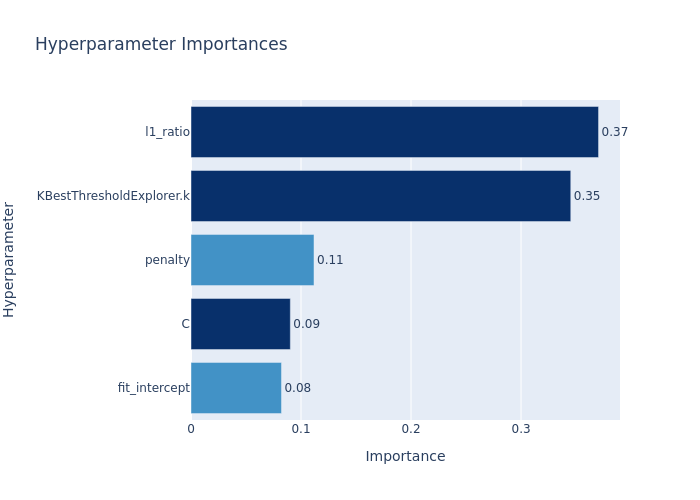

In [15]:
from IPython.display import Image

f = optuna.visualization.plot_param_importances(study)
Image(f.to_image(format="png", engine='kaleido'))

We can see that choosing the correct penalty, the value of C and number of features is critical to model performance. Some parameters like `fit_intercept` had very little impact. Rather than spending our time tuning these manually, Optuna HPO has handled it for us.

The following is a slice plot to better understand the parameter relationships. We see how the change in the parameter affects the performance of the model. 

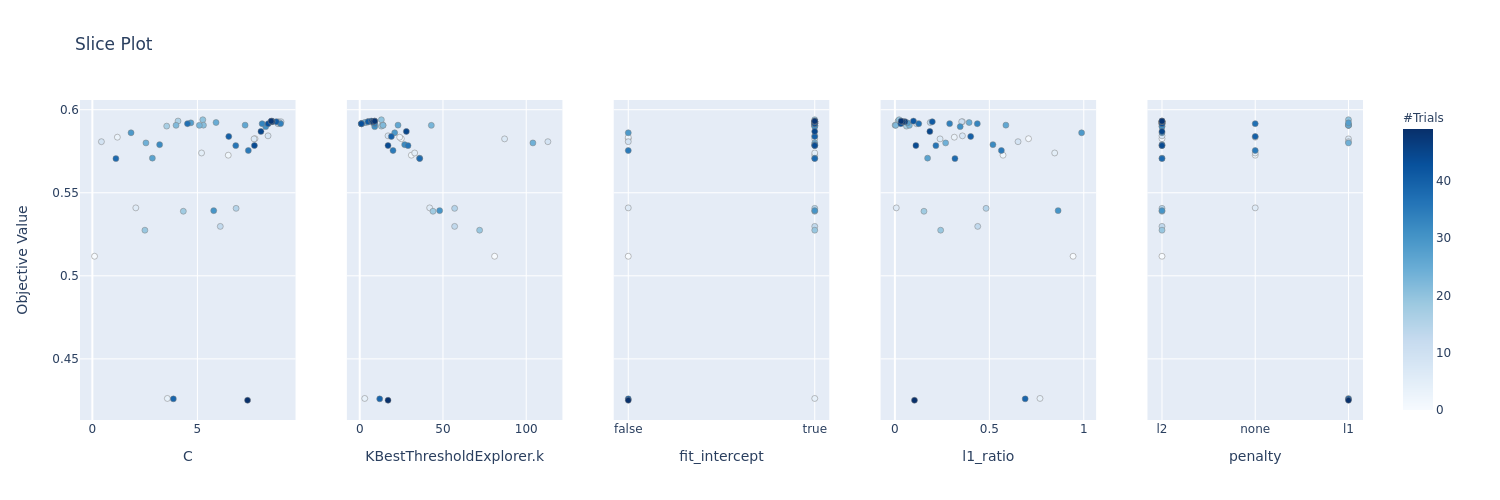

In [16]:
f = optuna.visualization.plot_slice(study, params=['l1_ratio', 'C', 'KBestThresholdExplorer.k', 'penalty', 'fit_intercept'])
Image(f.to_image(format="png", engine='kaleido'))

Let's plot the history of all trials in the study to see how the performance improvements took place within the study. We can see that we start from a poor performance around 0.60 and move towards 0.68.

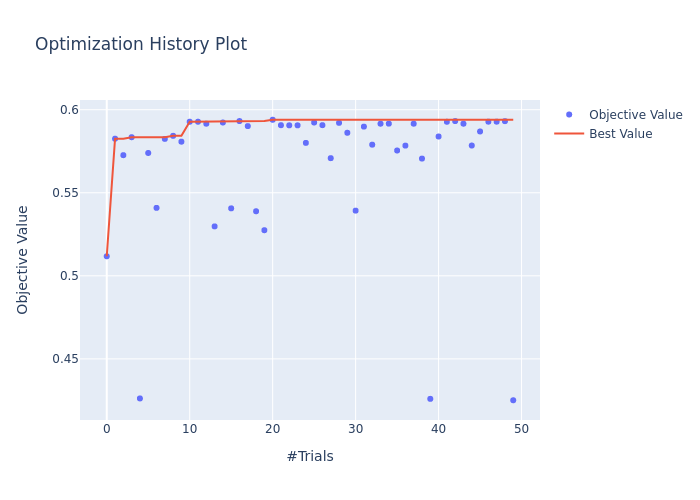

In [17]:
f = optuna.visualization.plot_optimization_history(study)
Image(f.to_image(format="png", engine='kaleido'))

Now, that we have seen the performance improvement, let's look at how we can retrieve this model with MLFlow.

### Launch our optimized model within the MLflow framework.
Run the code block below to identify the most recently registered model, with the 'rapids-optuna-airline' tag; after identifying the latest model version, run the code below in a separate terminal, and wait for it to fully load your model.

In [18]:
print(f"Run the command below in a terminal, and wait for it to load your model:\n\n  \
      {get_latest_mlflow_model(MLFLOW_TRACKING_URI, MLFLOW_MODEL_ID)}")

Run the command below in a terminal, and wait for it to load your model:

        MLFLOW_TRACKING_URI=sqlite:////tmp/mlflow-db.sqlite mlflow models serve --no-conda -m models:/rapids-optuna-airline/20 -p 56767


You should see output similar to the following:

```shell
2020/07/27 13:59:49 INFO mlflow.models.cli: Selected backend for flavor 'python_function'
2020/07/27 13:59:49 INFO mlflow.pyfunc.backend: === Running command 'source /anaconda3/bin/../etc/profile.d/conda.sh && conda activate mlflow-3335621df6011b1847d2555b195418d4496e5ffd 1>&2 && gunicorn --timeout=60 -b 127.0.0.1:5000 -w 1 ${GUNICORN_CMD_ARGS} -- mlflow.pyfunc.scoring_server.wsgi:app'
[2020-07-27 13:59:50 -0600] [23779] [INFO] Starting gunicorn 20.0.4
[2020-07-27 13:59:50 -0600] [23779] [INFO] Listening at: http://127.0.0.1:5000 (23779)
[2020-07-27 13:59:50 -0600] [23779] [INFO] Using worker: sync
[2020-07-27 13:59:50 -0600] [23788] [INFO] Booting worker with pid: 23788
```

In [19]:
host='localhost'
port='56767'

headers = {
    "Content-Type": "application/json",
    "format": "pandas-split"
}

data = { 
    "columns": ["Year", "Month", "DayofMonth", "DayofWeek", "CRSDepTime", "CRSArrTime", "UniqueCarrier",
                "FlightNum", "ActualElapsedTime", "Origin", "Dest", "Distance", "Diverted"],
    "data": [[1987, 10, 1, 4, 1, 556, 0, 190, 247, 202, 162, 1846, 0]]
}

while (True):
    try:
        resp = requests.post(url="http://%s:%s/invocations" % (host, port), data=json.dumps(data), headers=headers)
        print('Classification: %s' % ("ON-Time" if resp.text == "[0.0]" else "LATE"))
        break
    except Exception as e:
        errmsg = "Caught exception attempting to call model endpoint: %s" % e
        print(errmsg)
        print("... Sleeping ...")
        time.sleep(20)

## Closing Thoughts

We’ve seen how to use RAPIDS alongside xfeat and Optuna to get performance boosts both in terms of run-time and AUC score. The notebook can serve as a starting point for anyone looking to get started on using GPUs to run Hyperparameter Optimization and Feature Engineering experiments. These can add value by yielding better performing models much faster than CPU runs. MLflow helps in retaining the model information and makes it easier to save and load our best model, thus making it an useful choice for production. The combination of these libraries can save a lot of time and provide significant improvements in performance. 

To learn more:

[Target Encoding and Bayesian Target Encoding](https://towardsdatascience.com/target-encoding-and-bayesian-target-encoding-5c6a6c58ae8c)

[Learn more about using MLFlow with RAPIDS](https://github.com/mlflow/mlflow/tree/master/examples/rapids/mlflow_project)

[Algorithms for Hyper-Parameter Optimization](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)

Find the libraries: [RAPIDS](https://rapids.ai/), [xfeat](https://github.com/pfnet-research/xfeat/tree/master/xfeat), [Optuna](https://optuna.readthedocs.io/en/stable/), [MLFlow](https://mlflow.org/)